In [110]:
#Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

from scipy.stats import zscore
from sklearn.preprocessing import PowerTransformer, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
import pickle

In [2]:
#import the data 
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/DSData/master/loan_prediction.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


data is a mix of continuous and categorical data

In [4]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [5]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Filling Categorical Columns missing values with mode

In [6]:
df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
df['Married'].fillna(df['Married'].mode()[0],inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0],inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0],inplace=True)

Filling Continuous Columns missing values with mean

In [7]:
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean())
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mean())

In [8]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

now there are no null's in the data

In [9]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.000000,0.842199
std,6109.041673,2926.248369,84.037468,64.372489,0.349681
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


A higher std than mean in ApplicantIncome and CoapplicantIncome columns indicates skewness.

There is a huge difference between 75% and max in ApplicantIncome,CoapplicantIncome and LoanAmount, indicating presence of outliers.

In [10]:
df.nunique()

Loan_ID              614
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           204
Loan_Amount_Term      11
Credit_History         3
Property_Area          3
Loan_Status            2
dtype: int64

Gender,Married,Education,Self_Employed,Loan_Status each have 2 unique elements.

Dependents has 4 unique elements.

Credit_History,Property Area has 3 unique elements.

In [11]:
df['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

<Axes: xlabel='Loan_Status', ylabel='count'>

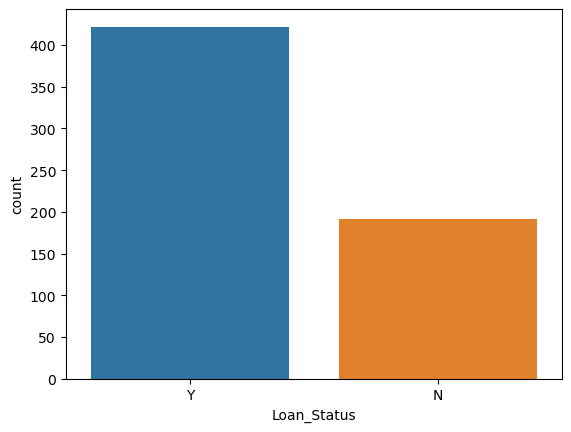

In [12]:
sns.countplot(x=df['Loan_Status'])

Loan of the applicants have more approved than rejected in this dataset.

<Axes: xlabel='Gender', ylabel='count'>

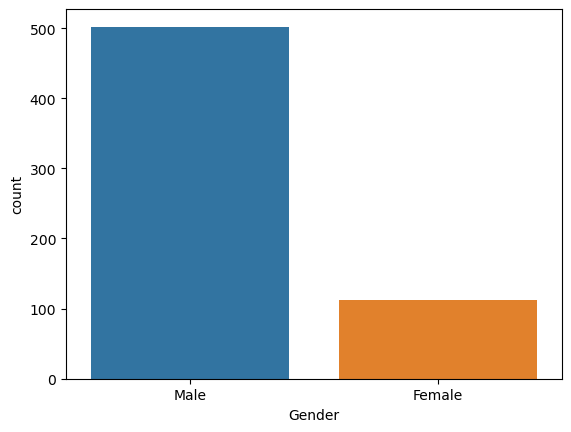

In [13]:
sns.countplot(x=df['Gender'])

There are more Male Applicants than Female Applicants.

<Axes: xlabel='Married', ylabel='count'>

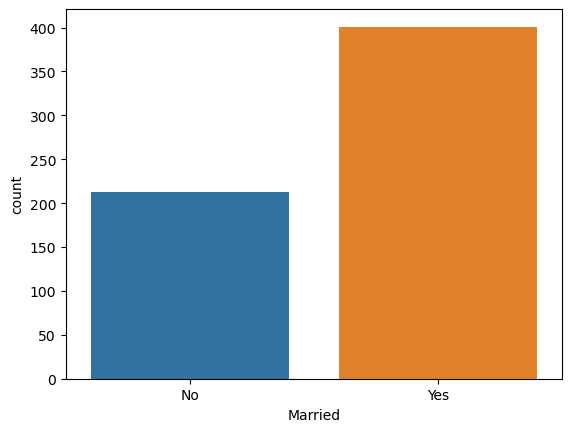

In [14]:
sns.countplot(x=df['Married'])

There are more applicants who are married than those who are not.

<Axes: xlabel='Dependents', ylabel='count'>

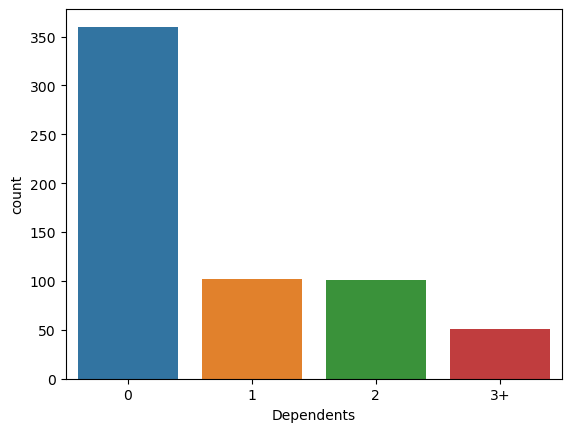

In [15]:
sns.countplot(x=df['Dependents'])

Most applicants have no dependents to support.

<Axes: xlabel='Education', ylabel='count'>

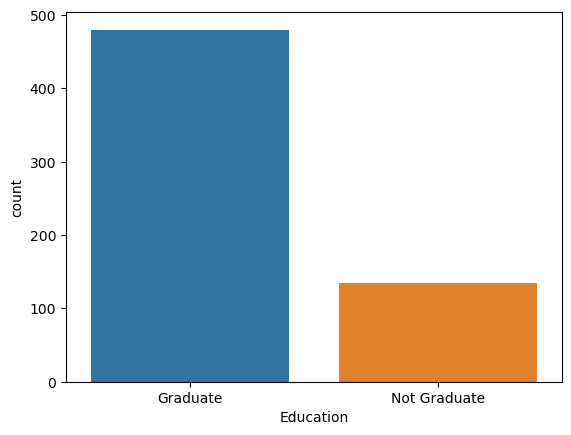

In [16]:
sns.countplot(x=df['Education'])

Most applicants are Graduates.

<Axes: xlabel='Self_Employed', ylabel='count'>

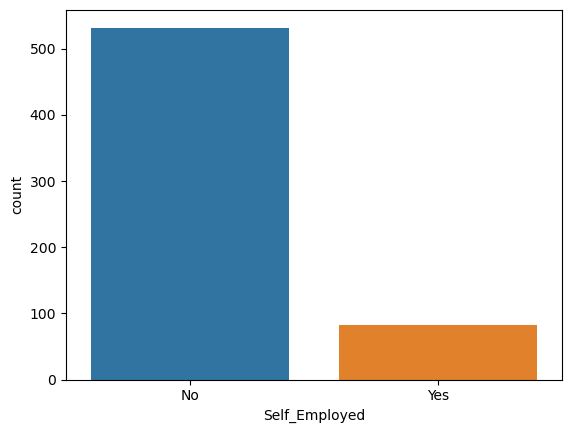

In [17]:
sns.countplot(x=df['Self_Employed'])

Most applicants are not Self Employed.

In [18]:
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

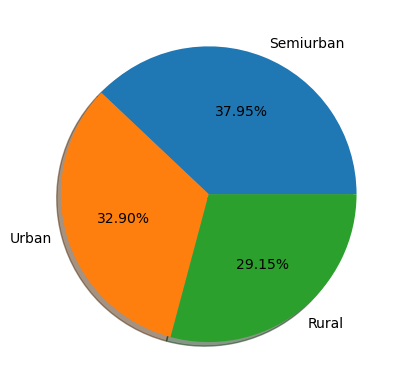

In [19]:
labels = 'Semiurban','Urban','Rural'
fig, ax = plt.subplots()
ax.pie(df['Property_Area'].value_counts(),labels = labels,radius =1,autopct = '%1.2f%%', shadow=True,)
plt.show()

37.95% applicants are from Semiurban, while 32.90% of applicants are from Urban and 29.15% are from Rural areas.

<Axes: xlabel='Property_Area', ylabel='count'>

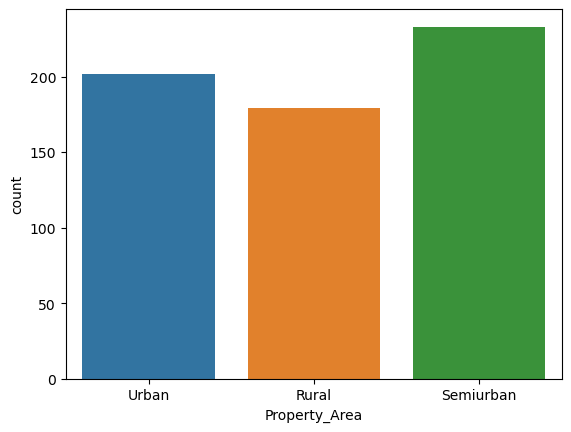

In [20]:
sns.countplot(x=df['Property_Area'])

Loan of semiurban applicants have accepted the most in the dataset.

Loan of rural applicants have rejected the most in the dataset.

<Axes: xlabel='Loan_Status', ylabel='count'>

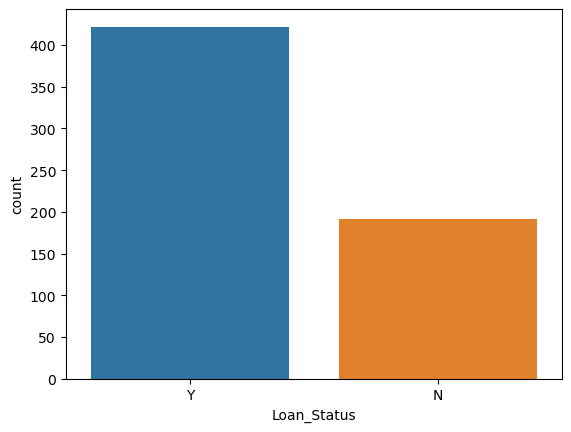

In [21]:
sns.countplot(x=df['Loan_Status'])

More Loans have approved than rejected.

Analysing Feature columns with Continuous Data

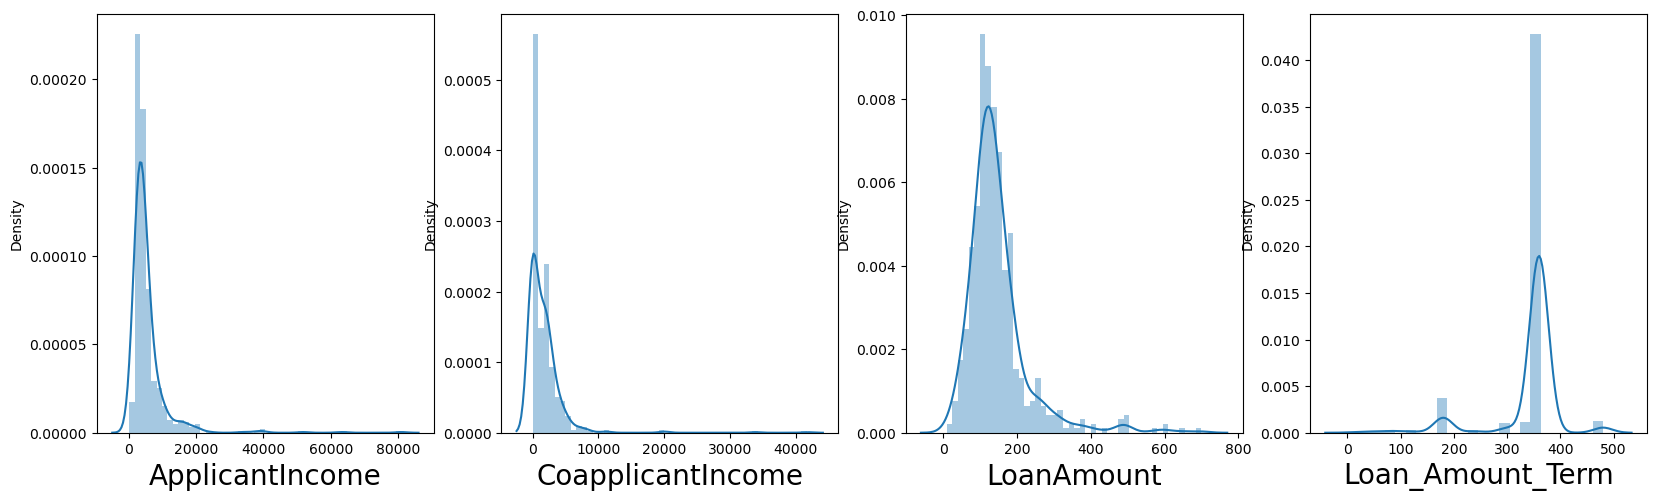

In [22]:
plt.figure(figsize=(20,25),facecolor='white')
plotnum=1
for col in df[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']]:
    if plotnum<=10:
        plt.subplot(4,4,plotnum)
        sns.distplot(df[col])
        plt.xlabel(col,fontsize=20)
    plotnum+=1
plt.show()

Data distributions are skewed

In [23]:
df[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']].skew()

ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.726601
Loan_Amount_Term    -2.389680
dtype: float64

'Loan_Status' vs Continuous/Discrete Data Columns

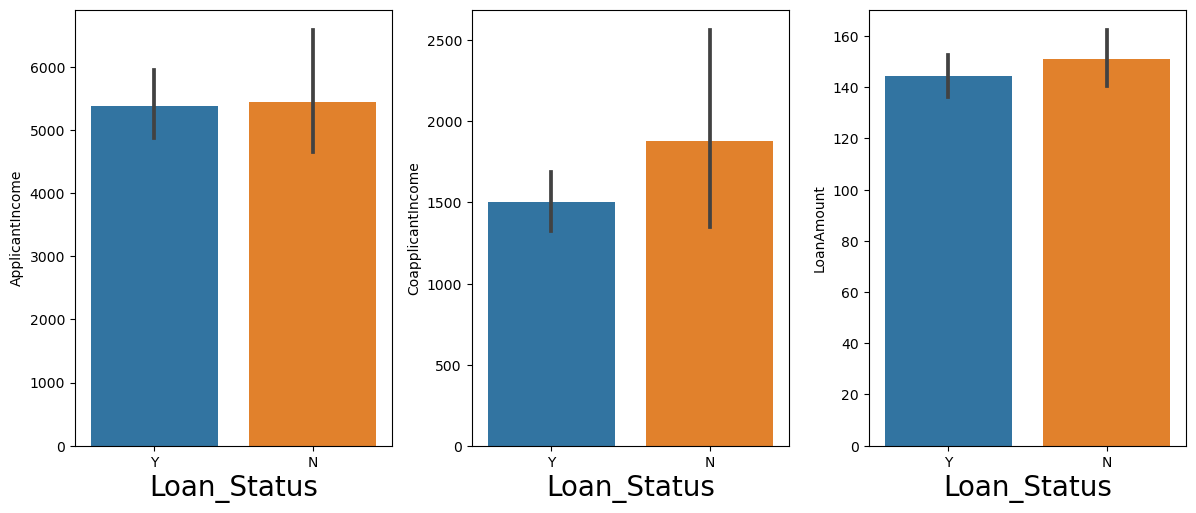

In [24]:
plt.figure(figsize=(20,25),facecolor='white')
plotnum=1
y = df['Loan_Status']
X = df[['ApplicantIncome','CoapplicantIncome','LoanAmount']]
for col in X:
    if plotnum<=15:
        plt.subplot(5,5,plotnum)
        sns.barplot(x=y,y=X[col])
        plt.xlabel('Loan_Status',fontsize=20)
        plt.ylabel(col,fontsize=10)
    plotnum+=1
plt.tight_layout()

Applicant income doesnt seem to contribute significantly to loan approval.

Loan rejection is high for higher Coapplicant Income.

LoanAmount doesn't seem to have a strong correlation with Loan Status.

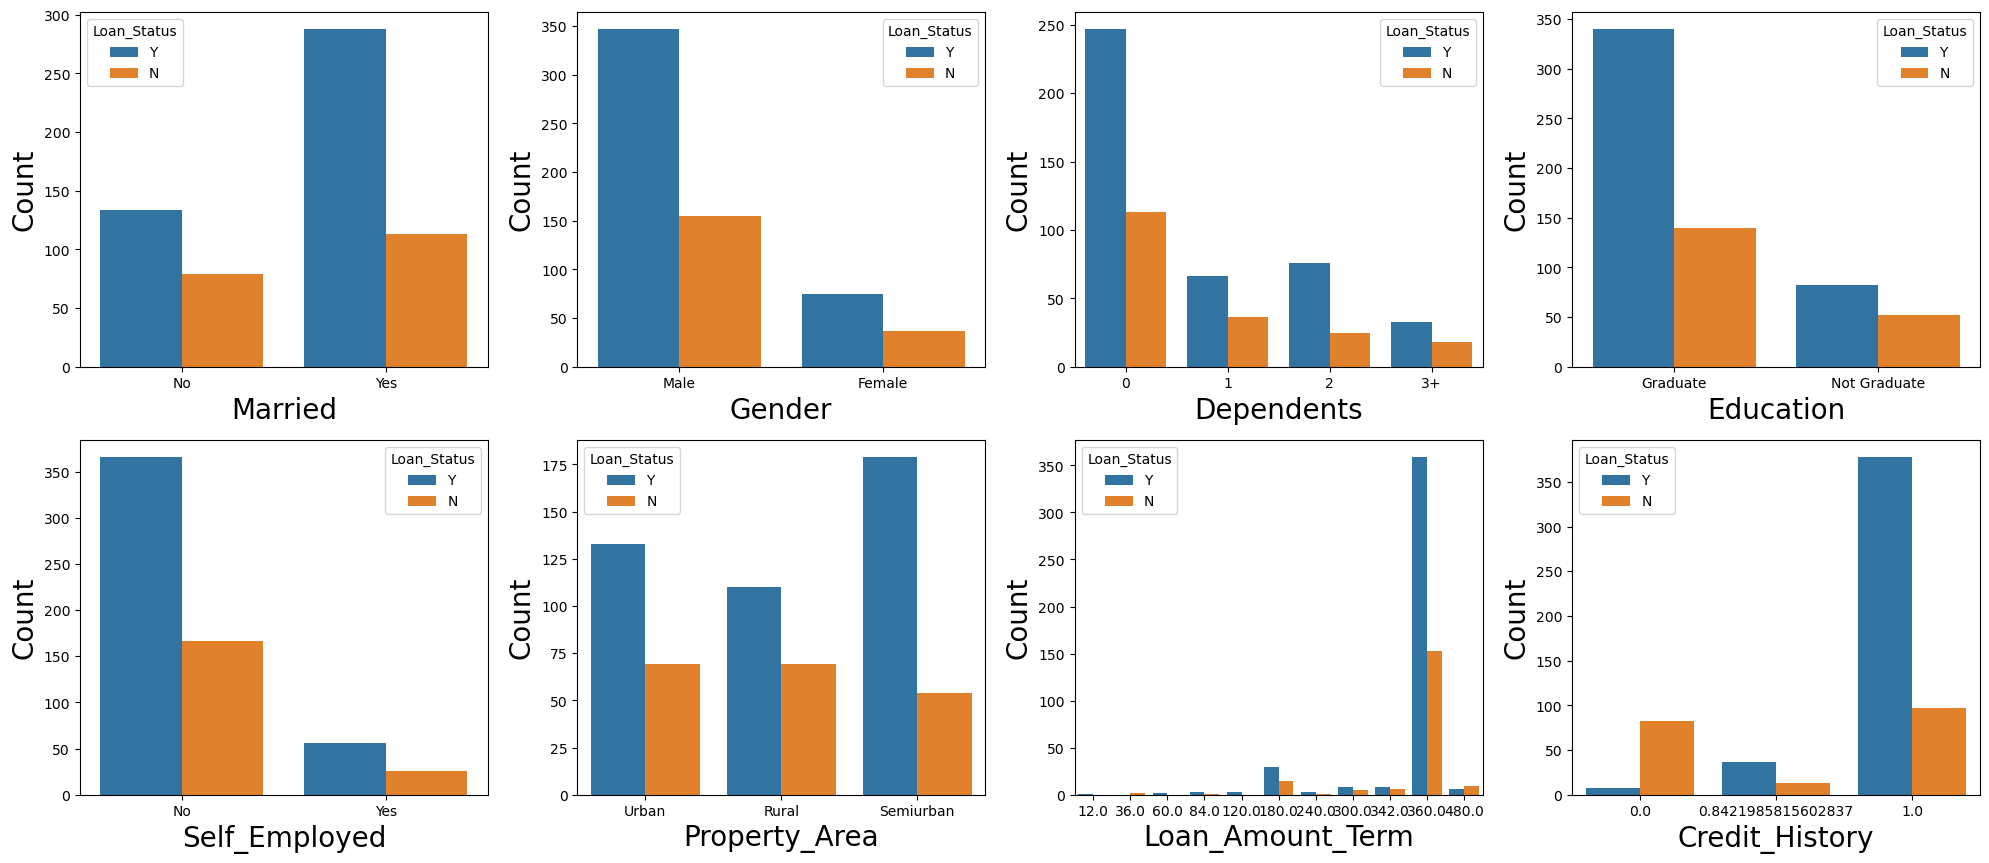

In [25]:
plt.figure(figsize=(20,21),facecolor='white')
plotnum=1
X = df[['Married','Gender','Dependents','Education','Self_Employed','Property_Area','Loan_Amount_Term','Credit_History']]
y = df['Loan_Status']
for col in X:
    if plotnum<=23:
        plt.subplot(5,4,plotnum)
        sns.countplot(x=X[col],hue =y)
        plt.xlabel(col,fontsize=20)
        plt.ylabel('Count',fontsize=20)
    plotnum+=1
plt.tight_layout()

Married applicants have higher loan approval.

More Male applicants get loan approval than Female applicants. This may also be due to the fact that there are more male applicants than female applicants.

Applicants with 0 dependents have highest loan approval.

Graduates have higher loan approval.

Applicants who are not self employed have higher loan approval.

Applicants from semi urban areas have highest loan approval.

Highest loan approval is for 360.

Applicants with Credit History of 1.0 has highest loan approval.

In [26]:
# we can drop Loan Id as its not usefull
df.drop(columns = ['Loan_ID'],inplace=True)
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y


In [27]:
x = df.drop(columns = ['Loan_Status'])
y = df['Loan_Status']

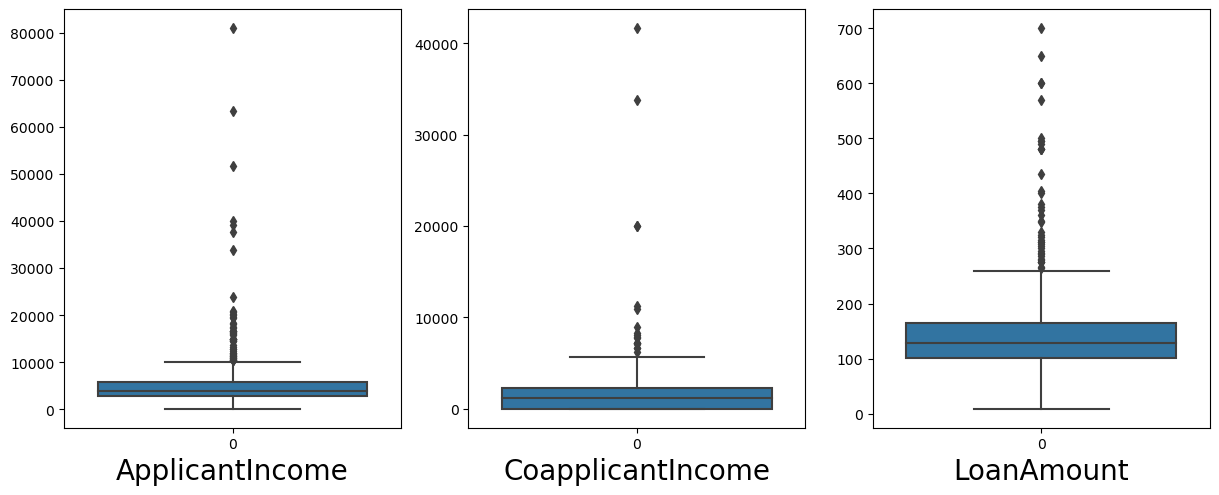

In [28]:
plt.figure(figsize=(20,25),facecolor='white')
plotnum=1
for col in x[['ApplicantIncome','CoapplicantIncome','LoanAmount']]:
    if plotnum<=16:
        plt.subplot(4,4,plotnum)
        sns.boxplot(x[col])
        plt.xlabel(col,fontsize=20)
    plotnum+=1
plt.show()

all 3 have outliers

Removing Outliers using Z score Method

In [29]:
df1 = x[['ApplicantIncome','CoapplicantIncome','LoanAmount']].copy()
df1

,ApplicantIncome,CoapplicantIncome,LoanAmount
0,5849,0.0,146.412162
1,4583,1508.0,128.000000
2,3000,0.0,66.000000
3,2583,2358.0,120.000000
4,6000,0.0,141.000000
...,...,...,...
609,2900,0.0,71.000000
610,4106,0.0,40.000000
611,8072,240.0,253.000000
612,7583,0.0,187.000000


In [30]:
zscor = zscore(df1)
z_score_abs = np.abs(zscor)

df2 = df1[(z_score_abs < 3).all(axis=1)] #taking 3 as threshold value

In [31]:
df1.shape, df2.shape

((614, 3), (589, 3))

% data lost

In [32]:
loss=(614-589)/614 * 100
loss

4.071661237785016

4.07% data loss is within acceptable range

In [33]:
dropindx = x.index.difference(df2.index)
dropindx

Int64Index([  9, 126, 130, 155, 171, 177, 183, 185, 278, 308, 333, 369, 402,
            409, 417, 432, 443, 487, 506, 523, 525, 561, 581, 600, 604],
           dtype='int64')

In [34]:
#dropping the outliers from original features Dataframe
df.drop(dropindx,inplace = True) 

In [35]:
df.reset_index(drop=True,inplace = True)
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
584,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y
585,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y
586,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y
587,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y


lets work on skewness

In [36]:
x = df.drop(columns = ['Loan_Status'])
y = df['Loan_Status']

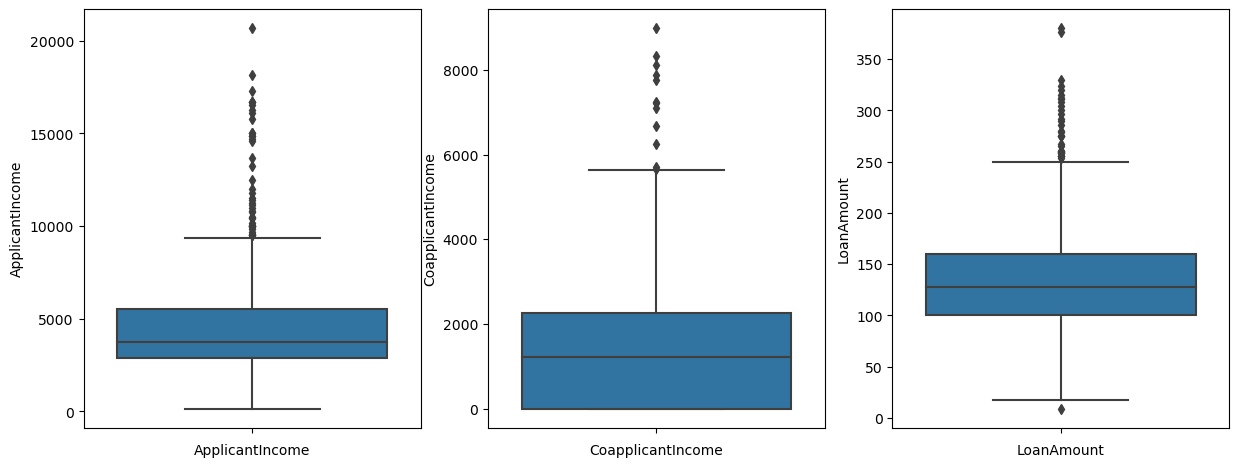

In [37]:
plt.figure(figsize=(20,25),facecolor='white')
plotnum=1
for col in x[['ApplicantIncome','CoapplicantIncome','LoanAmount']]:
    if plotnum<=16:
        plt.subplot(4,4,plotnum)
        sns.boxplot(y=x[col])
        plt.xlabel(col,fontsize=10)
    plotnum+=1
plt.show()

still have outliers 

In [38]:
x.skew()

ApplicantIncome      2.164762
CoapplicantIncome    1.353191
LoanAmount           1.076221
Loan_Amount_Term    -2.433130
Credit_History      -1.953298
dtype: float64

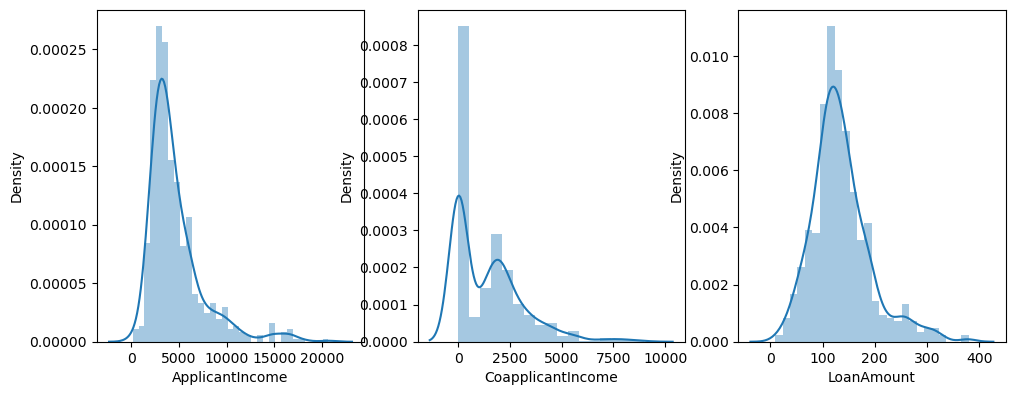

In [39]:
plt.figure(figsize=(20,25),facecolor='white')
plotnum=1
for col in x[['ApplicantIncome','CoapplicantIncome','LoanAmount']]:
    if plotnum<=35:
        plt.subplot(5,5,plotnum)
        sns.distplot(x[col])
        plt.xlabel(col,fontsize=10)
    plotnum+=1
plt.show()

Skewness exists in the data distributions. Let's reduce the skewness further using PowerTransformer

In [40]:
powtrans= PowerTransformer(method='yeo-johnson', standardize=True)
df3 = x[['ApplicantIncome','CoapplicantIncome','LoanAmount']]
transformed= powtrans.fit_transform(df3)
transformed = pd.DataFrame(transformed, columns=df3.columns) #to convert numpy array back into dataframe
transformed.skew()

ApplicantIncome      0.028063
CoapplicantIncome   -0.186195
LoanAmount           0.060143
dtype: float64

In [41]:
transformed.index = x.index

In [42]:
df[['ApplicantIncome','CoapplicantIncome','LoanAmount']] = transformed[['ApplicantIncome','CoapplicantIncome','LoanAmount']]
df.skew()

ApplicantIncome      0.028063
CoapplicantIncome   -0.186195
LoanAmount           0.060143
Loan_Amount_Term    -2.433130
Credit_History      -1.953298
dtype: float64

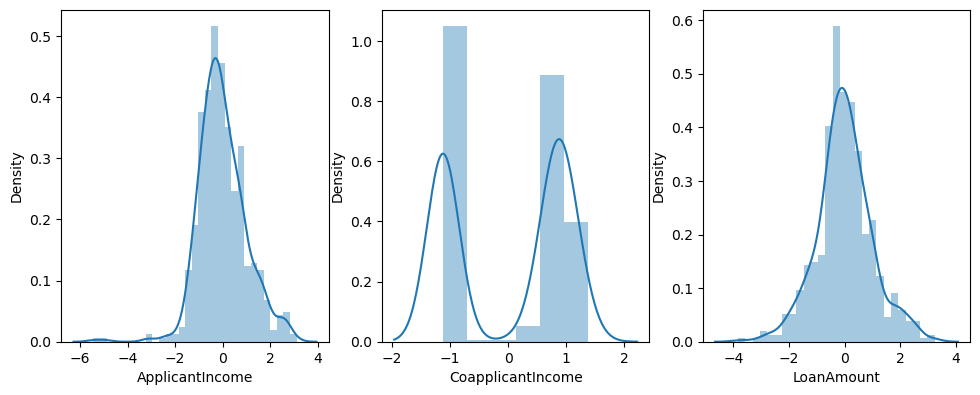

In [43]:
plt.figure(figsize=(20,25),facecolor='white')
plotnum=1
for col in df[['ApplicantIncome','CoapplicantIncome','LoanAmount']]:
    if plotnum<=35:
        plt.subplot(5,5,plotnum)
        sns.distplot(df[col])
        plt.xlabel(col,fontsize=10)
    plotnum+=1
plt.show()

Distributions look much more Normalised.

Encoding the categorical column

In [44]:
x[['Gender','Married','Education','Self_Employed','Property_Area']].nunique()

Gender           2
Married          2
Education        2
Self_Employed    2
Property_Area    3
dtype: int64

In [45]:
#Encoding using get_dummies()
dummies = pd.get_dummies(X[['Gender','Married','Education','Self_Employed','Property_Area']],drop_first = False)
dummies

,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,1,1,0,1,0,1,0,0,0,1
1,0,1,0,1,1,0,1,0,1,0,0
2,0,1,0,1,1,0,0,1,0,0,1
3,0,1,0,1,0,1,1,0,0,0,1
4,0,1,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
609,1,0,1,0,1,0,1,0,1,0,0
610,0,1,0,1,1,0,1,0,1,0,0
611,0,1,0,1,1,0,1,0,0,0,1
612,0,1,0,1,1,0,1,0,0,0,1


In [46]:
df = df.join(dummies)

In [47]:
df.drop(columns = ['Gender','Married','Education','Self_Employed','Property_Area'],axis = 1, inplace = True)
df

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,0.688986,-1.119438,0.316179,360.0,1.0,Y,0,1,1,0,1,0,1,0,0,0,1
1,1,0.239843,0.748807,-0.012325,360.0,1.0,N,0,1,0,1,1,0,1,0,1,0,0
2,0,-0.525799,-1.119438,-1.391277,360.0,1.0,Y,0,1,0,1,1,0,0,1,0,0,1
3,0,-0.791841,0.899419,-0.163769,360.0,1.0,Y,0,1,0,1,0,1,1,0,0,0,1
4,0,0.736280,-1.119438,0.222283,360.0,1.0,Y,0,1,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,0,-0.586262,-1.119438,-1.257035,360.0,1.0,Y,0,1,0,1,1,0,1,0,1,0,0
585,3+,0.039489,-1.119438,-2.209951,180.0,1.0,Y,0,1,0,1,1,0,1,0,1,0,0
586,1,1.291744,0.180599,1.855658,360.0,1.0,Y,0,1,0,1,1,0,1,0,0,0,1
587,2,1.173950,-1.119438,0.962614,360.0,1.0,Y,1,0,1,0,0,1,1,0,0,1,0


In [48]:
df['Dependents'].value_counts()

0     350
2      98
1      96
3+     45
Name: Dependents, dtype: int64

In [49]:
df['Dependents'] = df.Dependents.map({'0':0,'1':1,'2':2,'3+':3})
df['Loan_Status'] = df.Loan_Status.map({'N':0,'Y':1}) #'No' = 1 and 'Yes' = 0
df

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,0.688986,-1.119438,0.316179,360.0,1.0,1,0,1,1,0,1,0,1,0,0,0,1
1,1,0.239843,0.748807,-0.012325,360.0,1.0,0,0,1,0,1,1,0,1,0,1,0,0
2,0,-0.525799,-1.119438,-1.391277,360.0,1.0,1,0,1,0,1,1,0,0,1,0,0,1
3,0,-0.791841,0.899419,-0.163769,360.0,1.0,1,0,1,0,1,0,1,1,0,0,0,1
4,0,0.736280,-1.119438,0.222283,360.0,1.0,1,0,1,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,0,-0.586262,-1.119438,-1.257035,360.0,1.0,1,0,1,0,1,1,0,1,0,1,0,0
585,3,0.039489,-1.119438,-2.209951,180.0,1.0,1,0,1,0,1,1,0,1,0,1,0,0
586,1,1.291744,0.180599,1.855658,360.0,1.0,1,0,1,0,1,1,0,1,0,0,0,1
587,2,1.173950,-1.119438,0.962614,360.0,1.0,1,1,0,1,0,0,1,1,0,0,1,0


lets look at correlation

In [50]:
corr = df.corr()
corr

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
Dependents,1.000000,0.105559,0.001199,0.128371,-0.088304,-0.014654,0.021937,-0.023344,0.023344,0.045281,-0.045281,0.018641,-0.018641,0.007020,-0.007020,0.009361,-0.003916,-0.004954
ApplicantIncome,0.105559,1.000000,-0.359986,0.438097,-0.040969,0.032011,-0.003320,-0.027669,0.027669,-0.079829,0.079829,0.003362,-0.003362,0.031713,-0.031713,0.060266,0.007185,-0.065344
CoapplicantIncome,0.001199,-0.359986,1.000000,0.196155,0.012664,0.000218,0.080277,0.011502,-0.011502,0.019539,-0.019539,0.036878,-0.036878,-0.029404,0.029404,-0.002433,0.005646,-0.003491
LoanAmount,0.128371,0.438097,0.196155,1.000000,0.094820,-0.012470,-0.039999,-0.006950,0.006950,-0.045031,0.045031,0.041760,-0.041760,0.025067,-0.025067,0.004042,-0.009615,0.006042
Loan_Amount_Term,-0.088304,-0.040969,0.012664,0.094820,1.000000,-0.007756,-0.021418,0.065554,-0.065554,-0.026831,0.026831,-0.068163,0.068163,0.022169,-0.022169,0.004752,-0.023126,0.019309
Credit_History,-0.014654,0.032011,0.000218,-0.012470,-0.007756,1.000000,0.555902,0.098476,-0.098476,0.071536,-0.071536,0.014947,-0.014947,0.017575,-0.017575,0.079642,-0.043527,-0.031609
Loan_Status,0.021937,-0.003320,0.080277,-0.039999,-0.021418,0.555902,1.000000,0.051006,-0.051006,0.051264,-0.051264,-0.016531,0.016531,-0.001927,0.001927,0.042408,-0.048967,0.009796
Gender_Female,-0.023344,-0.027669,0.011502,-0.006950,0.065554,0.098476,0.051006,1.000000,-1.000000,0.360901,-0.360901,0.038760,-0.038760,-0.003263,0.003263,-0.077483,0.106045,-0.035013
Gender_Male,0.023344,0.027669,-0.011502,0.006950,-0.065554,-0.098476,-0.051006,-1.000000,1.000000,-0.360901,0.360901,-0.038760,0.038760,0.003263,-0.003263,0.077483,-0.106045,0.035013
Married_No,0.045281,-0.079829,0.019539,-0.045031,-0.026831,0.071536,0.051264,0.360901,-0.360901,1.000000,-1.000000,0.009617,-0.009617,0.002466,-0.002466,0.007029,-0.012403,0.006050


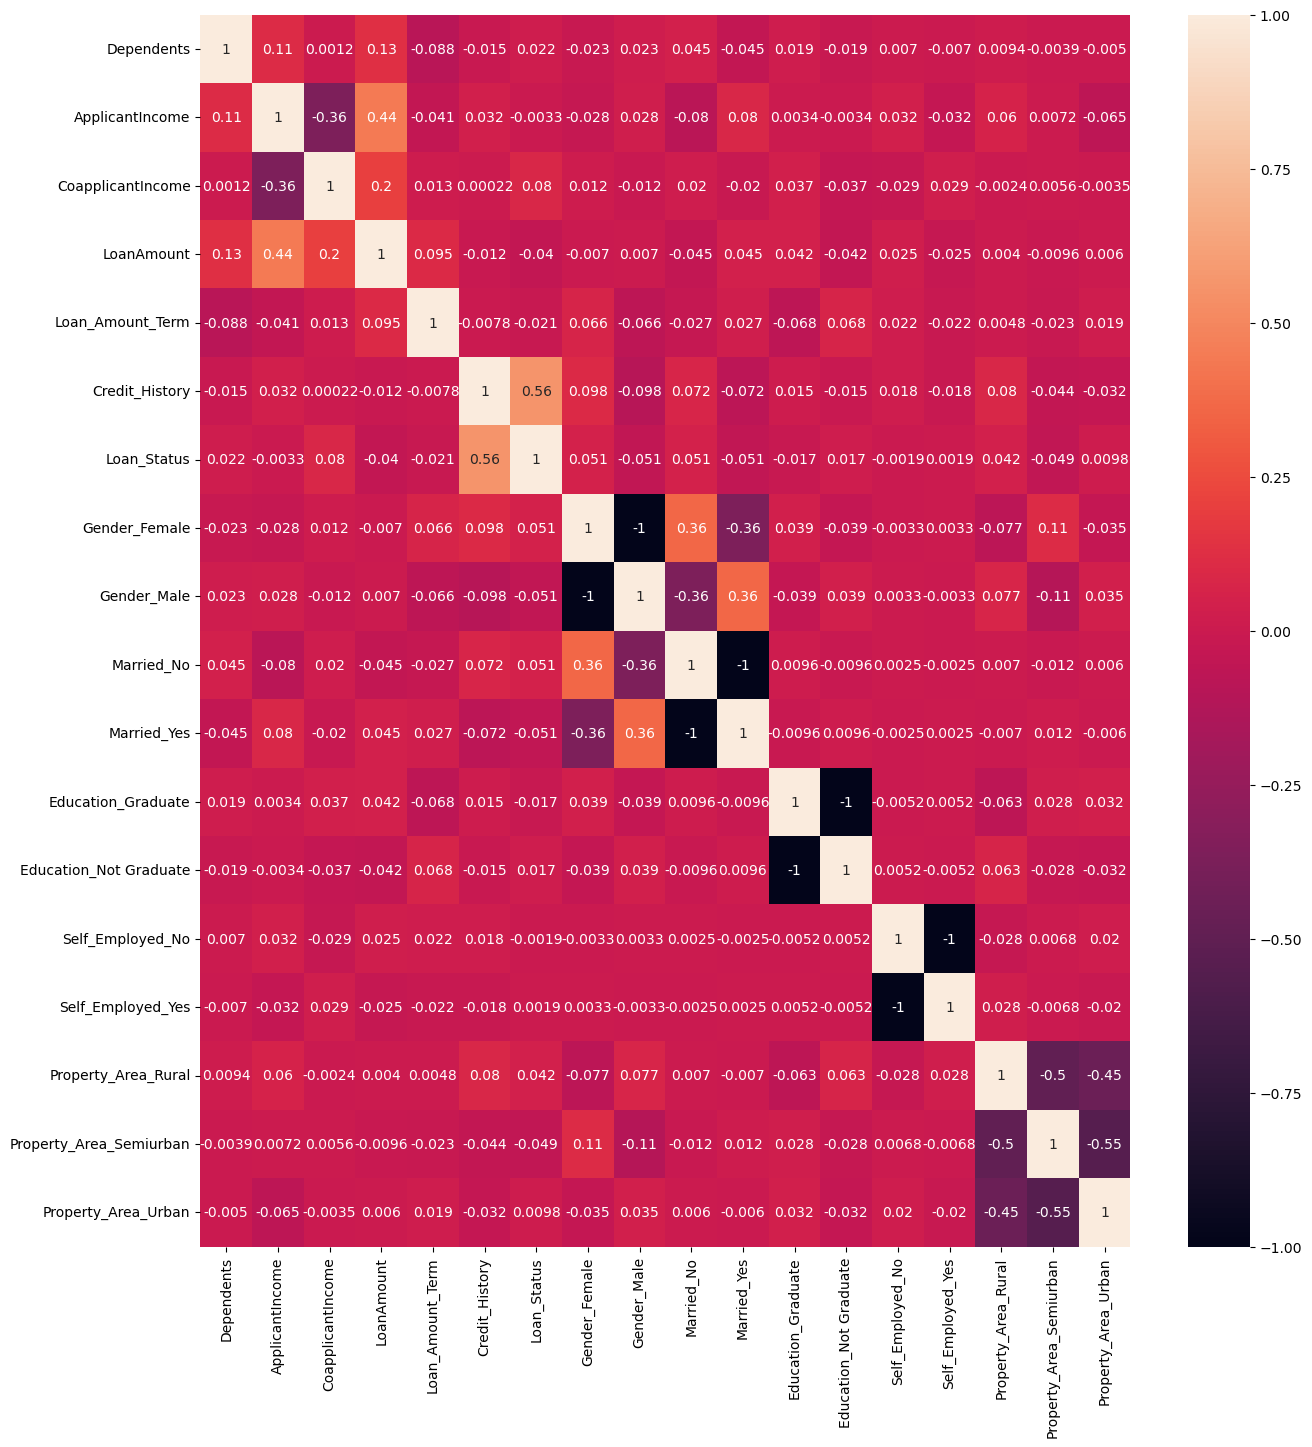

In [51]:
plt.figure(figsize=(15,16))
sns.heatmap(corr,annot=True,)
plt.show()

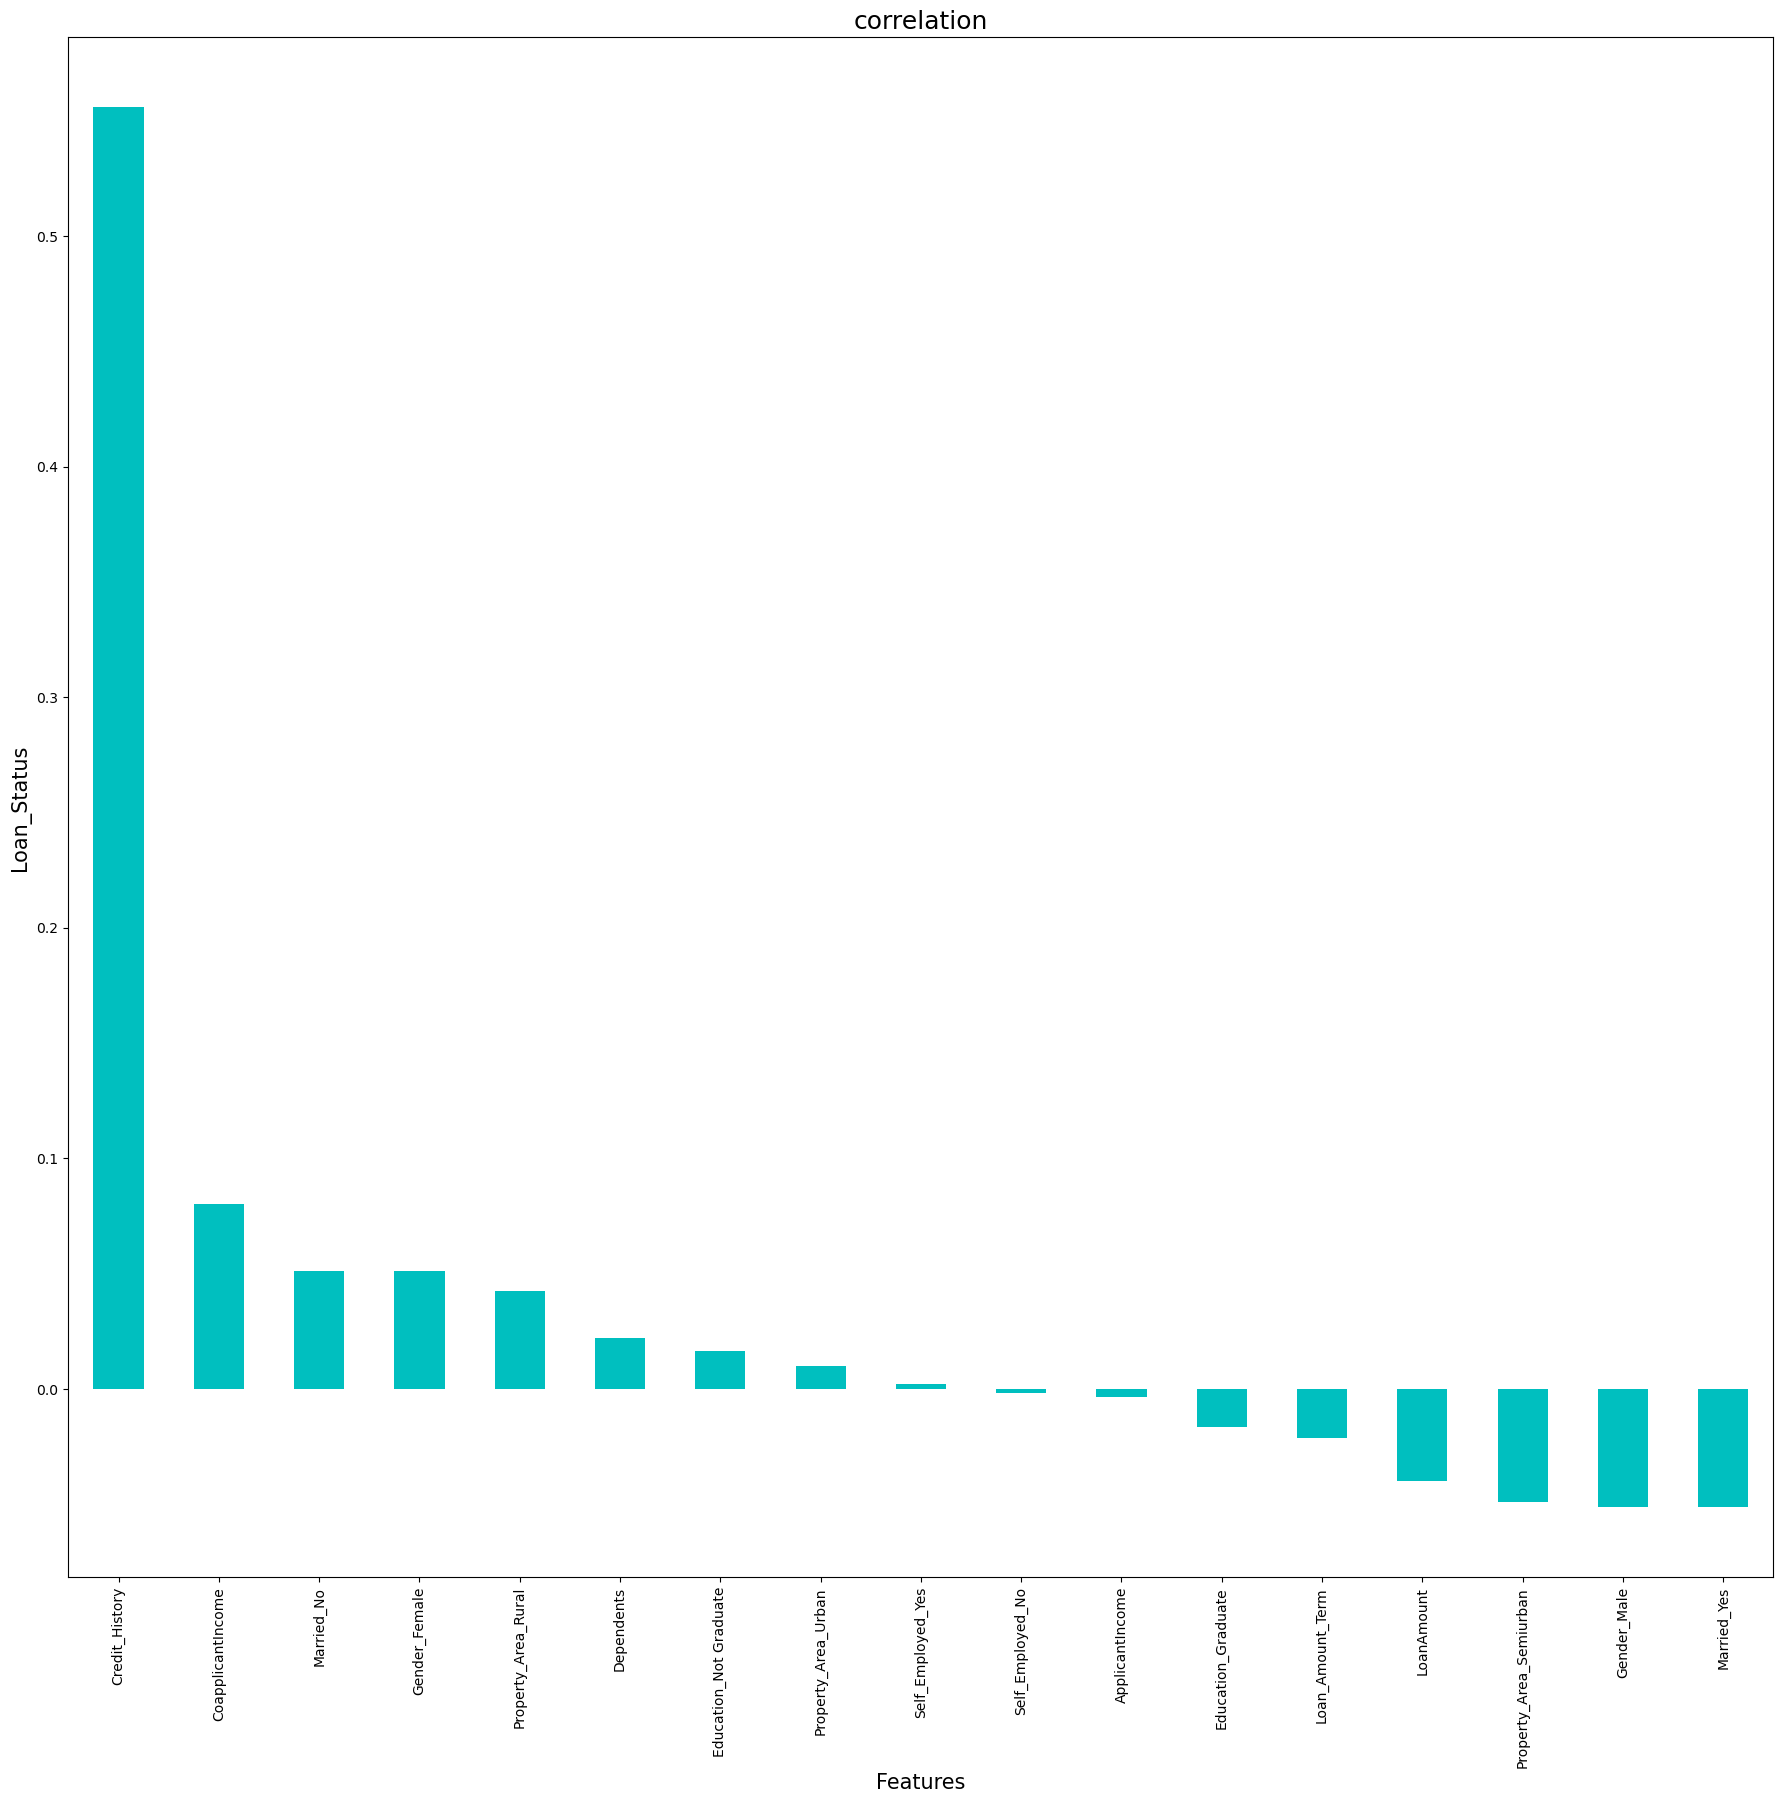

In [52]:
plt.figure(figsize = (22,20))
df.corr()['Loan_Status'].sort_values(ascending = False).drop(['Loan_Status']).plot(kind='bar',color = 'c')
plt.xlabel('Features',fontsize=15)
plt.ylabel('Loan_Status',fontsize=15)
plt.title('correlation',fontsize = 18)
plt.show()

Credit_History, Property_Area_Semiurban,Married_Yes,Education_Graduate have the highest positive correlation with Loan_Status, while Propert_Area_Rural,Married_No,Education_Not Graduate have the highest negative correlation with Loan_Status.

In [53]:
x = df.drop(columns = ['Loan_Status'])
y = df['Loan_Status']

Scaler

We will standardise our feature data for using Standard Scaler after that we will divide our dataset into train data and test data.

In [54]:
scaler= StandardScaler()
scaled_X = scaler.fit_transform(x)
scaled_X

array([[-0.72840172,  0.68898634, -1.11943846, ..., -0.63433505,
        -0.78621363,  1.42144744],
       [ 0.27634913,  0.23984329,  0.74880747, ...,  1.57645396,
        -0.78621363, -0.70350825],
       [-0.72840172, -0.52579862, -1.11943846, ..., -0.63433505,
        -0.78621363,  1.42144744],
       ...,
       [ 0.27634913,  1.29174432,  0.18059936, ..., -0.63433505,
        -0.78621363,  1.42144744],
       [ 1.28109999,  1.17394957, -1.11943846, ..., -0.63433505,
         1.27191894, -0.70350825],
       [-0.72840172,  0.23984329, -1.11943846, ..., -0.63433505,
         1.27191894, -0.70350825]])

Checking for Multicollinearity using Variance Inflation Factor

In [55]:
vif = pd.DataFrame()
vif["Features"] = x.columns
vif['vif'] = [variance_inflation_factor(scaled_X,i) for i in range(scaled_X.shape[1])]
vif

,Features,vif
0,Dependents,1.034320
1,ApplicantIncome,1.714118
2,CoapplicantIncome,1.409305
3,LoanAmount,1.558927
4,Loan_Amount_Term,1.045282
5,Credit_History,1.022785
6,Gender_Female,inf
7,Gender_Male,inf
8,Married_No,inf
9,Married_Yes,inf


There is no Multicollinearity

Principle Component Analysis

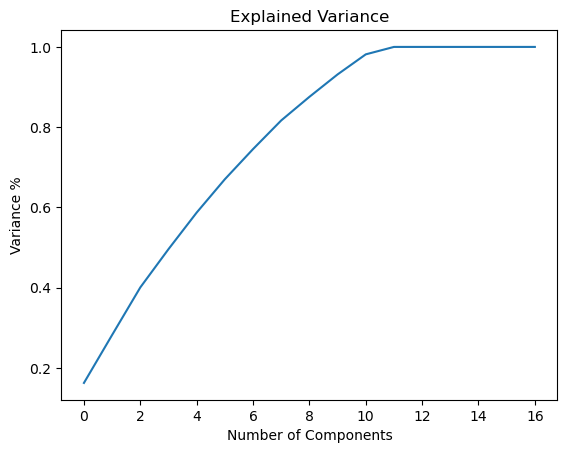

In [56]:
pca = PCA()
principleComponents = pca.fit_transform(scaled_X)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance %')
plt.title('Explained Variance')
plt.show()

12 components explain around 95% variance in Data

In [57]:
pca = PCA(n_components=11)
new_comp = pca.fit_transform(scaled_X)
principle_x=pd.DataFrame(new_comp,columns=np.arange(11))
principle_x

,0,1,2,3,4,5,6,7,8,9,10
0,0.812754,-0.449979,-0.817380,1.695090,0.582017,-0.956648,1.118560,-0.847783,-1.318262,-1.114010,0.257120
1,-1.197498,-0.496973,-0.467548,0.379142,1.101859,1.273217,-1.192084,0.493301,0.290861,0.071166,-0.304478
2,-1.044568,-1.290240,3.524356,1.172441,-1.008715,-0.963900,-0.363294,-1.943462,-0.254482,-0.617040,-0.506883
3,-1.359880,2.415962,-0.144613,1.130085,-1.557010,-1.041724,-0.701017,0.563461,0.471197,-0.771805,0.372885
4,0.813033,-0.444139,-0.814463,1.697615,0.569636,-0.939298,1.127037,-0.904381,-1.314341,-1.107406,0.243796
...,...,...,...,...,...,...,...,...,...,...,...
584,-1.147216,-0.252896,-0.361753,0.605036,0.263201,1.834465,-1.253350,-1.650174,-0.337558,0.095523,-0.392321
585,-1.184405,-0.546178,-0.375137,0.614678,1.042166,2.105936,0.851182,-2.054798,2.949833,1.253630,-0.881278
586,-1.286080,-1.034507,-1.004217,0.540300,1.094671,-2.127709,-0.257219,0.723776,0.078788,-0.733098,0.188960
587,3.194936,2.778297,-0.518696,-2.232436,1.151911,-1.498936,0.702467,-0.104530,0.515948,0.041502,-0.644222


Selecting Kbest Features

In [58]:
bestfeat = SelectKBest(score_func = f_classif, k = 17)
fit = bestfeat.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

In [59]:
fit = bestfeat.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
dfcolumns.head()
featureScores = pd.concat([dfcolumns,dfscores],axis = 1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(17,'Score'))

                    Feature       Score
5            Credit_History  262.526492
2         CoapplicantIncome    3.807431
9               Married_Yes    1.546677
8                Married_No    1.546677
6             Gender_Female    1.531115
7               Gender_Male    1.531115
15  Property_Area_Semiurban    1.410887
14      Property_Area_Rural    1.057568
3                LoanAmount    0.940656
0                Dependents    0.282620
4          Loan_Amount_Term    0.269388
11   Education_Not Graduate    0.160459
10       Education_Graduate    0.160459
16      Property_Area_Urban    0.056334
1           ApplicantIncome    0.006468
12         Self_Employed_No    0.002181
13        Self_Employed_Yes    0.002181


In [60]:
x_best = x.drop(columns=['ApplicantIncome','Self_Employed_Yes','Self_Employed_No','Dependents']).copy()
x_best

,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,-1.119438,0.316179,360.0,1.0,0,1,1,0,1,0,0,0,1
1,0.748807,-0.012325,360.0,1.0,0,1,0,1,1,0,1,0,0
2,-1.119438,-1.391277,360.0,1.0,0,1,0,1,1,0,0,0,1
3,0.899419,-0.163769,360.0,1.0,0,1,0,1,0,1,0,0,1
4,-1.119438,0.222283,360.0,1.0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,-1.119438,-1.257035,360.0,1.0,0,1,0,1,1,0,1,0,0
585,-1.119438,-2.209951,180.0,1.0,0,1,0,1,1,0,1,0,0
586,0.180599,1.855658,360.0,1.0,0,1,0,1,1,0,0,0,1
587,-1.119438,0.962614,360.0,1.0,1,0,1,0,0,1,0,1,0


In [61]:
scaled_x_best = scaler.fit_transform(x_best)

Classification Model Building

In [62]:
maxAcc = 0
maxRS=0
for i in range(1,100):
    x_train,x_test,y_train,y_test = train_test_split(scaled_x_best,y,test_size = .31, random_state = i,stratify = y)
    reg =  LogisticRegression()
    reg.fit(x_train,y_train)
    pred = reg.predict(x_test)
    acc  = accuracy_score(y_test,pred)
    if acc>maxAcc:
        maxAcc=acc
        maxRS=i
print(f"Best Accuracy is: {maxAcc} on random_state: {maxRS}")

Best Accuracy is: 0.8633879781420765 on random_state: 41


In [63]:
x_train,x_test,y_train,y_test = train_test_split(scaled_x_best,y,test_size = .2, stratify = y,random_state = 41) 

Models

In [71]:
knn = KNeighborsClassifier()
svr = SVR()
rf = RandomForestClassifier()
adbc = AdaBoostClassifier()
lr= LogisticRegression(solver='liblinear')

In [72]:
models = [knn, svr, rf, adbc, lr]

In [73]:
for i in models:
    i.fit(x_train,y_train)
    pred = i.predict(x_test)
    score=i.score(x_train,y_train)
    print(f'{i} had score of {round((score*100),2)}% and r2_score is {r2_score(y_test,pred)}')
    print('')

KNeighborsClassifier() had score of 81.1% and r2_score is 0.320460704607046

SVR() had score of 36.29% and r2_score is 0.5026801344117982

RandomForestClassifier() had score of 99.36% and r2_score is 0.320460704607046

AdaBoostClassifier() had score of 82.38% and r2_score is 0.3604336043360433

LogisticRegression(solver='liblinear') had score of 80.04% and r2_score is 0.48035230352303515



RandomForestClassifier gives 99.36% accurate. So we will go with RandomForestClassifier. But lets do cross_check

In [74]:
# cross validation for Linear Regression
cvs1 = cross_val_score(knn,scaled_x_best,y,cv = 5)
print("Cross Validation Score for Linear Regression is ", cvs1.mean())

Cross Validation Score for Linear Regression is  0.7843256555120962


In [76]:
# cross validation for Ridge Regression
cvs2 = cross_val_score(svr,scaled_x_best,y,cv = 5)
print("Cross Validation Score for Ridge Regression is ", cvs2.mean())

Cross Validation Score for Ridge Regression is  0.247328711763224


In [77]:
# cross validation for Lasso Regression
cvs3 = cross_val_score(rf,scaled_x_best,y,cv = 5)
print("Cross Validation Score for Lasso Regression is ", cvs3.mean())

Cross Validation Score for Lasso Regression is  0.7623931623931623


In [78]:
# cross validation for Elastic Net
cvs4 = cross_val_score(adbc,scaled_x_best,y,cv = 5)
print("Cross Validation Score for Elastic Net is ", cvs4.mean())

Cross Validation Score for Elastic Net is  0.8030421555845285


In [79]:
# cross validation for KNeighborsRegressor
cvs5 = cross_val_score(lr,scaled_x_best,y,cv = 5)
print("Cross Validation Score for KNeighborsRegressor is ", cvs5.mean())

Cross Validation Score for KNeighborsRegressor is  0.8166594234390845


In [83]:
for i in models:
    i.fit(x_train,y_train)
    pred = i.predict(x_test)
    r= roc_auc_score(y_test,pred)
    print('roc_auc_score for ', i, r)
    print('')

roc_auc_score for  KNeighborsClassifier() 0.771680216802168

roc_auc_score for  SVR() 0.845189701897019

roc_auc_score for  RandomForestClassifier() 0.8184281842818428

roc_auc_score for  AdaBoostClassifier() 0.8167344173441734

roc_auc_score for  LogisticRegression(solver='liblinear') 0.8272357723577237



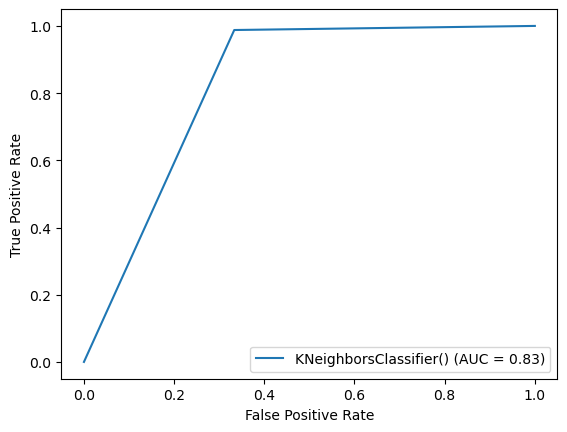

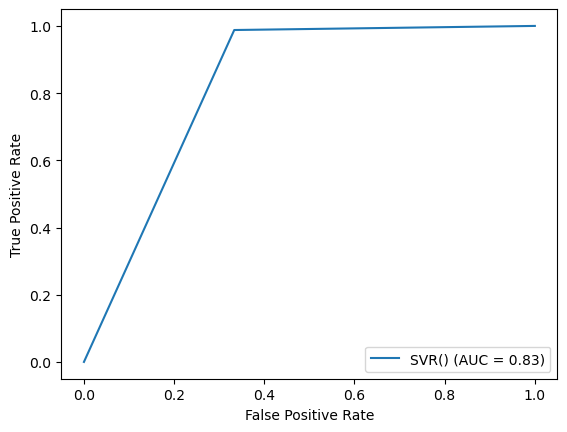

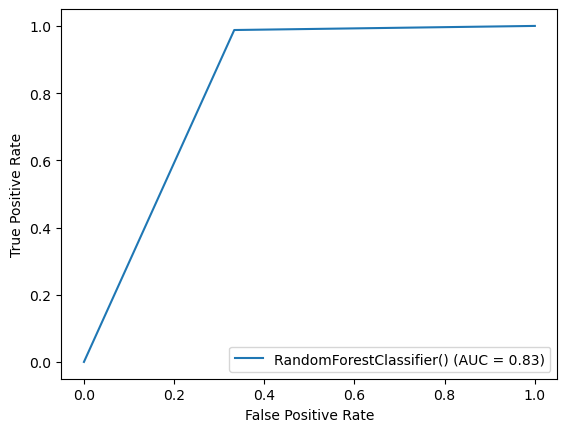

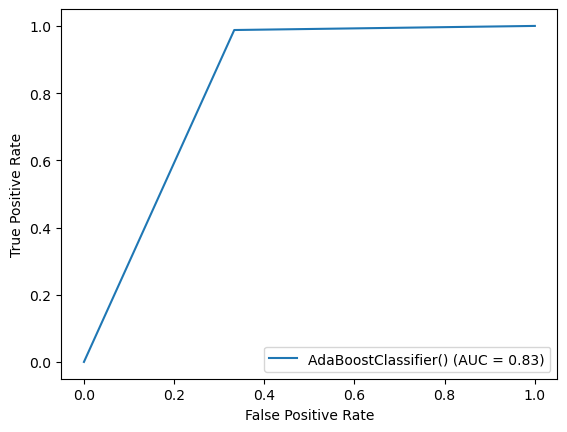

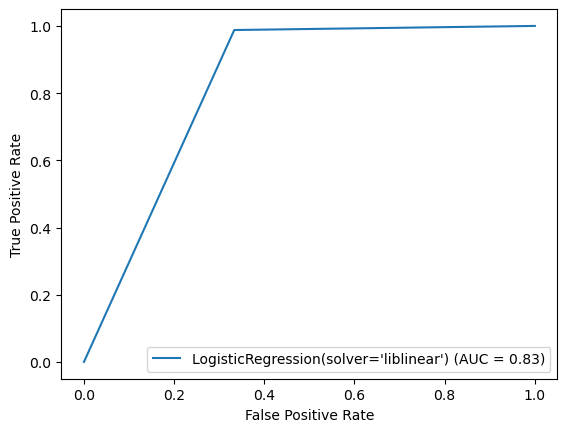

In [104]:
for i in models:
    fpr, tpr, thresholds=metrics.roc_curve(y_test, pred)
    auc=metrics.auc(fpr,tpr)
    view=metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc,estimator_name=i)
    view.plot()

Hyper Parameter Tuning

In [100]:
parameter = {'n_estimators':[200,400,500,600],'gamma':np.arange(0,0.2,0.1),
              'booster' : ['gbtree','dart','gblinear'], 'max_depth':[4,6,8,10],
              'eta' : [0.001, 0.01, 0.1] } 

In [101]:
grid = GridSearchCV(estimator=rf, param_grid=parameter, cv=5,n_jobs = -1,verbose=2)

Model Saving

In [111]:
file_name = 'BestModelLoan.pickle'
pickle.dump(rf,open(file_name,'wb'))

In [112]:
#get the saved model
saved_model = pickle.load(open(file_name,'rb'))

In [115]:
# predicting with the loaded model
predictions = saved_model.predict(x_test)

In [116]:
# making dataframe
conclusion = pd.DataFrame({})
conclusion['Predictions'] = predictions
conclusion['Actual'] = pred
conclusion

,Predictions,Actual
0,1,1
1,1,1
2,1,1
3,0,0
4,0,0
...,...,...
113,0,0
114,1,1
115,1,1
116,0,0
